In [3]:
import numpy as np
from scipy import interpolate, stats
import matplotlib.pyplot as plt
import pandas as pd
import geopy.distance
from scipy.stats import norm

In [4]:
df = pd.read_csv("../data/Fresno_Water_Rights.csv")
print(df.columns)

Index(['geometry', 'POD_ID', 'APPL_ID', 'POD_NUM', 'TOWNSHIP_NUMBER',
       'TOWNSHIP_DIRECTION', 'RANGE_NUMBER', 'RANGE_DIRECTION',
       'SECTION_NUMBER', 'SECTION_CLASSIFIER', 'QUARTER', 'QUARTER_QUARTER',
       'MERIDIAN', 'NORTH_COORD', 'EAST_COORD', 'SP_ZONE', 'LATITUDE',
       'LONGITUDE', 'TRIB_DESC', 'Location_Method', 'SOURCE_NAME', 'Moveable',
       'Has_OPOD', 'WATERSHED', 'COUNTY', 'WELL_NUMBER', 'QUAD_MAP_NAME',
       'QUAD_MAP_NUM', 'QUAD_MAP_MIN_SER', 'PARCEL_NUMBER',
       'DIVERSION_SITE_NAME', 'SPECIAL_AREA', 'HUC_12', 'HUC_8', 'HU_8_NAME',
       'HU_12_NAME', 'DIRECT_DIV_AMOUNT', 'DIVERSION_STORAGE_AMOUNT',
       'DIVERSION_AC_FT', 'POD_STATUS', ' FACE_VALUE_AMOUNT ',
       'DIVERSION_TYPE', 'DIVERSION_CODE_TYPE', 'WR_TYPE', 'WR_STATUS',
       'STORAGE_TYPE', 'POD_UNIT', 'FIRST_NAME', 'LAST_NAME', 'ENTITY_TYPE'],
      dtype='object')


In [5]:
df = df.dropna(subset=['LATITUDE', 'LONGITUDE', 'DIRECT_DIV_AMOUNT', 'POD_UNIT'])
df2 = df[['LATITUDE', 'LONGITUDE', 'DIRECT_DIV_AMOUNT', 'POD_UNIT']]

# There are multiple diversions on some locations
df2 = df2.groupby(['LATITUDE', 'LONGITUDE', 'POD_UNIT'], as_index = False).sum()

In [6]:
df2 = df2[df2["DIRECT_DIV_AMOUNT"] != 0]

In [7]:
x = df2["LATITUDE"].values
y = df2["LONGITUDE"].values
z = df2["DIRECT_DIV_AMOUNT"].values # Should we include storage div amounts
# What are the units? Are the units different depending on the units column?

In [8]:
df2.groupby(['POD_UNIT'])['DIRECT_DIV_AMOUNT'].describe()

,count,mean,std,min,25%,50%,75%,max
POD_UNIT,,,,,,,,
Cubic Feet per Second,232.0,1953.658871,3362.274465,0.002,2.23,175.0,4500.0,32953.0
Gallons per Day,286.0,3039.386364,4703.431183,3.000,200.00,600.0,5957.5,36000.0
Gallons per Minute,10.0,2431.800000,1451.199182,18.000,1500.00,3500.0,3500.0,3500.0


(array([381., 112.,  17.,  10.,   3.,   0.,   2.,   0.,   1.,   2.]),
 array([2.00000000e-03, 3.60000180e+03, 7.20000160e+03, 1.08000014e+04,
        1.44000012e+04, 1.80000010e+04, 2.16000008e+04, 2.52000006e+04,
        2.88000004e+04, 3.24000002e+04, 3.60000000e+04]),
 <a list of 10 Patch objects>)

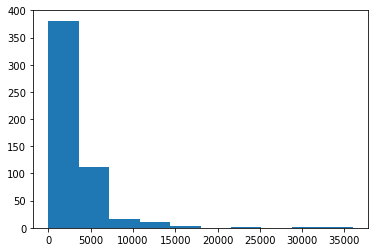

In [9]:
plt.hist(z)

In [10]:
stats.describe(z)

DescribeResult(nobs=528, minmax=(0.002, 36000.0), mean=2550.816965909091, variance=17241687.57831448, skewness=3.4282176310423638, kurtosis=18.30684740815012)

In [11]:
s = np.empty(len(z))

for i in range(0, len(z)):
    
    lat1 = x[i]
    long1 = y[i]
    
    dist_sum = 0
    
    for j in range(0, len(z)):
        
        if i == j:
            next
        
        lat2 = x[j]
        long2 = y[j]
        
        dist_sum = dist_sum + geopy.distance.distance((lat1, long1), (lat2, long2)).km
        
    s[i] = dist_sum / (len(z) - 1)

In [12]:
import geof
print(geof.geo_dist.__doc__)

s12 = geo_dist(lat1,lon1,lat2,lon2)

Wrapper for ``geo_dist``.

Parameters
----------
lat1 : input float
lon1 : input float
lat2 : input float
lon2 : input float

Returns
-------
s12 : float



In [38]:
import math

def norm_pdf(x, mean = 0, scale = 1):
    
    factor = 1/(scale * math.sqrt(2*math.pi))
    
    exponent = -0.5*((x - mean)/scale)**2
    
    return factor*math.exp(exponent)
    

In [28]:
norm.pdf(5, scale = 3)

0.03315904626424956

In [31]:
norm_pdf(5, scale = 3)

0.03315904626424956

In [39]:
def water_right_score(lat, long):
    
    score = 0
    
    disp = np.mean(s)/2
    
    for i in range(0, len(z)):
        
        lat1 = x[i]
        long1 = y[i]
        right1 = z[i]
        disp1 = s[i]/2
        
        dist = geof.geo_dist(lat1, long1, lat, long)
        #dist = geopy.distance.distance((lat1, long1), (lat, long)).km
        
        #amnt = norm.pdf(dist, scale = disp)
        amnt = norm_pdf(dist, scale = disp)
        
        #print(right1,"\t",dist,"\t",amnt)
        
        score = score + right1*amnt
        
    return score

In [14]:
geof.geo_dist(36.1, -119, 36, -119.5)

46.399583242603676

In [15]:
geopy.distance.distance((36.1, -119), (36, -119.5)).km

46.399583242603676

In [16]:
stats.describe(x)

DescribeResult(nobs=528, minmax=(35.9961773, 37.46789265), mean=36.80226565535985, variance=0.11895423235272785, skewness=-0.46449815146669243, kurtosis=-0.640381074918738)

In [17]:
stats.describe(y)

DescribeResult(nobs=528, minmax=(-120.80045530000001, -118.6798), mean=-119.6087769939394, variance=0.3094009127144158, skewness=-0.8062618322321279, kurtosis=-0.7000862858459329)

In [43]:
x_up = 37.46789265
x_low = 35.97575564
y_up = -118.6798
y_low = -120.8004553

xnew = np.arange(x_low, x_up, (x_up - x_low)/200)[0:200]
ynew = np.arange(y_low, y_up, (y_up - y_low)/200)[0:200]

In [44]:
xv, yv = np.meshgrid(xnew, ynew)
fv = np.vectorize(water_right_score)
zv = fv(xv,yv)
stats.describe(zv.flatten())

DescribeResult(nobs=40000, minmax=(27.272178653270906, 6600.776233996347), mean=2933.4980417542797, variance=2847795.424013629, skewness=0.07940098178023852, kurtosis=-0.8529354790371553)

In [20]:
%load_ext line_profiler

In [40]:
%lprun -f norm_pdf water_right_score(36.0,119.0)

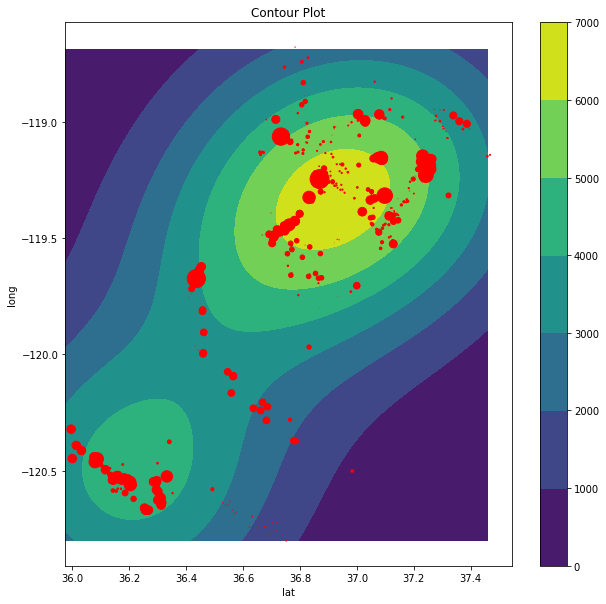

In [45]:
fig, ax = plt.subplots(figsize=(10, 10))

cp = plt.contourf(xv, yv, zv)
plt.colorbar(cp)

plt.scatter(x,y, s = z/100, c = 'r')

ax.set_title('Contour Plot')
ax.set_xlabel('lat')
ax.set_ylabel('long')
plt.show()